<h1>Audio Classification</h1>

In [8]:
import pandas as pd
import numpy as np
import xgboost as xgb
import pickle
import matplotlib
import matplotlib.pyplot as plt
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.class_weight import compute_class_weight
import itertools
from IPython.display import display

%matplotlib inline

In [2]:
x_train = pd.read_csv('../preprocessed/audio_train.csv')
x_test = pd.read_csv('../preprocessed/audio_test.csv')

print(x_train.shape)
y_train = x_train['label']
y_test = x_test['label']

(41, 10)


In [16]:
x_train.head()

,sig_mean,sig_std,rmse_mean,rmse_std,silence,harmonic,auto_corr_max,auto_corr_std
0,0.123917,0.149980,0.123645,0.163728,1.000000,0.03862,0.138853,0.158187
1,0.678767,0.674604,0.677814,0.675047,0.141989,1.00000,0.647323,0.683607
2,0.123917,0.149980,0.123645,0.163728,1.000000,0.03862,0.138853,0.158187
3,0.678767,0.674604,0.677814,0.675047,0.141989,1.00000,0.647323,0.683607
4,0.823041,0.806157,0.821983,0.799277,0.000000,0.72972,0.783899,0.810797


In [3]:
print(x_train.shape, x_test.shape)
cl_weight = dict(pd.Series(x_train['label']).value_counts(normalize=True))
print(dict(pd.Series(x_train['label']).value_counts()))

del x_train['label']
del x_test['label']
del x_train['wav_file']
del x_test['wav_file']

(41, 10) (11, 10)
{4: 36, 2: 4, 0: 1}


In [4]:
emotion_dict = {
    'ang': 0,
    'hap': 1,
    'sad': 2,
    'fea': 3,
    'sur': 4,
    'neu': 5}

emo_keys = list(['ang', 'hap', 'sad', 'fea', 'sur', 'neu'])

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """This function prints and plots the confusion matrix. Normalization can be applied by setting `normalize=True`."""
    
    # plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        # newaxis is also called as a pseudo-index that allows the temporary addition of an axis into a multiarray.
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    # temp = np.array(true_labels[:, num_records])
    temp = np.array(true_labels[:])
    # Rows, Columns
    true_labels = np.zeros((num_records, num_classes))
    
    # It will set the value 1 at the index like [rows, columns]
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_result(y_test, pred_probs, cm=True):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
    print('Test Set Accuracy = {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-Socre = {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
    print('Test Set Precision = {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
    print('Test Set Recall = {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
    
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emo_keys)

Test Set Accuracy = 0.182
Test Set F-Socre = 0.103
Test Set Precision = 0.061
Test Set Recall = 0.333
Confusion matrix, without normalization
[[0 1 0]
 [0 2 0]
 [0 8 0]]


/home/neel/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


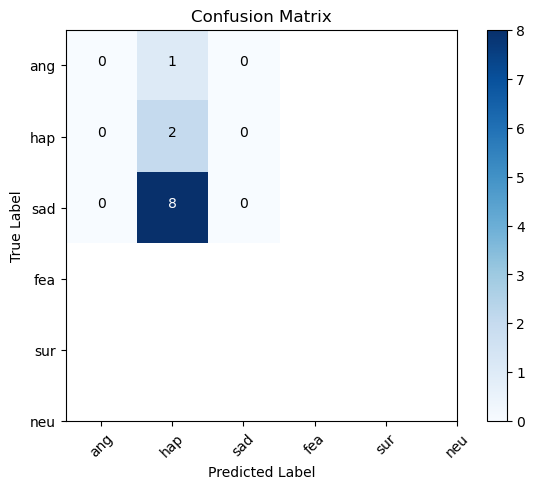

In [5]:
rf_classifier = RandomForestClassifier(n_estimators=1200, min_samples_split=25)
rf_classifier.fit(x_train, y_train)

# Predict
pred_probs = rf_classifier.predict_proba(x_test)

# Results
display_result(y_test, pred_probs)

with open('../preprocessed/rf_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

[19:55:24] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[19:55:24] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/neel/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/neel/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[[0.00179886 0.00294423 0.99525684]
 [0.01563371 0.03036436 0.95400196]
 [0.00179886 0.00294423 0.99525684]
 [0.03454567 0.8749141  0.09054024]
 [0.03317646 0.01212397 0.9546996 ]
 [0.01563371 0.03036436 0.95400196]
 [0.03317646 0.01212397 0.9546996 ]
 [0.01440263 0.35694087 0.62865657]
 [0.00365701 0.03650371 0.9598392 ]
 [0.03317646 0.01212397 0.9546996 ]
 [0.05465442 0.8021026  0.143243  ]]
Test Set Accuracy = 0.091
Test Set F-Socre = 0.045
Test Set Precision = 0.028
Test Set Recall = 0.125
Confusion matrix, without normalization
[[0 1 0 0]
 [0 0 0 0]
 [0 1 1 0]
 [0 0 8 0]]


/home/neel/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/neel/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


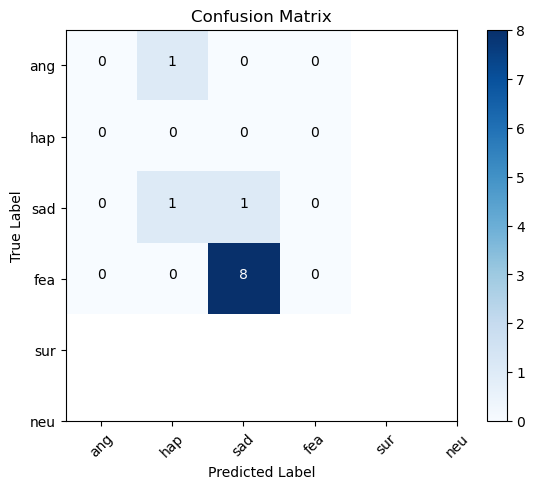

In [6]:
xgB_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.008, objective='multi:softprob', n_estimators=1200, sub_sample=0.8, num_class=len(emotion_dict), booster='gbtree', n_jobs=4)

xgB_classifier.fit(x_train, y_train)

# Predict
pred_probs = xgB_classifier.predict_proba(x_test)

print(pred_probs)

# Results
display_result(y_test, pred_probs.tolist())

with open('../preprocessed/xgb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

Test Set Accuracy = 0.091
Test Set F-Socre = 0.042
Test Set Precision = 0.025
Test Set Recall = 0.125
Confusion matrix, without normalization
[[0 0 1 0]
 [0 0 0 0]
 [0 1 1 0]
 [0 0 8 0]]


/home/neel/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/neel/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


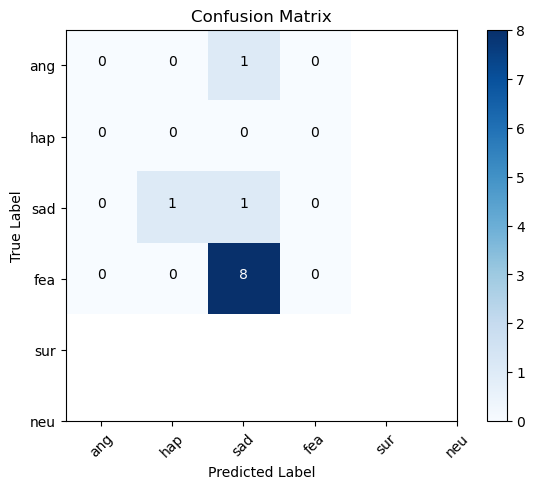

In [9]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(650, ), activation='relu', solver='adam', alpha=0.0001, batch_size='auto', learning_rate='adaptive', learning_rate_init=0.01, power_t=0.5, max_iter=1000, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=True, momentum=0.8, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

mlp_classifier.fit(x_train, y_train)

# Predict
pred_probs = mlp_classifier.predict_proba(x_test)

# Results
display_result(y_test, pred_probs)

with open('../preprocessed/mlp_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

In [12]:
svc_classifier = LinearSVC()
svc_classifier.fit(x_train, y_train)

# Predict
pred_probs = svc_classifier.predict(x_test)

# Results
display_result(y_test, pred_probs)

with open('../preprocessed/svc_classifier_model.pkl', 'wb') as f:
    pickle.dump(svc_classifier, f)

TypeError: object of type 'numpy.int64' has no len()

Test Set Accuracy = 0.182
Test Set F-Socre = 0.103
Test Set Precision = 0.061
Test Set Recall = 0.333
Confusion matrix, without normalization
[[0 1 0]
 [0 2 0]
 [0 8 0]]


/home/neel/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


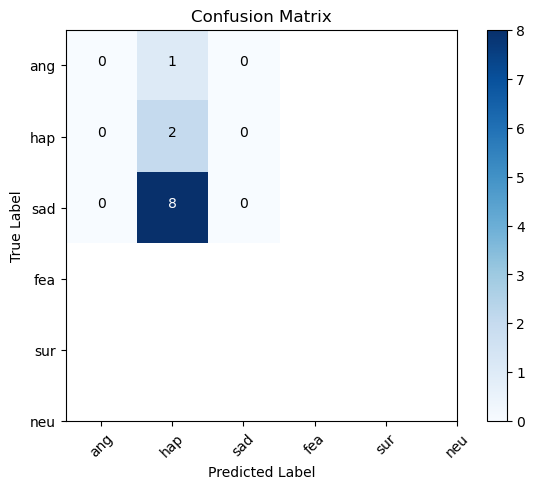

In [13]:
mnb_classifier = MultinomialNB()

mnb_classifier.fit(x_train, y_train)

# Predict
pred_probs = mnb_classifier.predict_proba(x_test)

# Results
display_result(y_test, pred_probs)

with open('../preprocessed/mnb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

Test Set Accuracy = 0.182
Test Set F-Socre = 0.103
Test Set Precision = 0.061
Test Set Recall = 0.333
Confusion matrix, without normalization
[[0 1 0]
 [0 2 0]
 [0 8 0]]


/home/neel/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


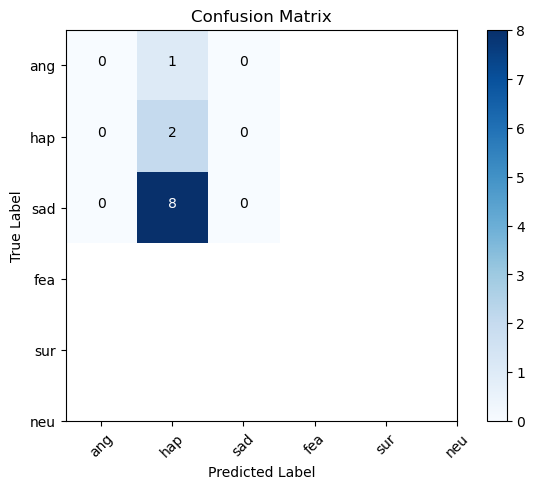

In [14]:
lr_classifier = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)

lr_classifier.fit(x_train, y_train)

# Predict
pred_probs = lr_classifier.predict_proba(x_test)

# Results
display_result(y_test, pred_probs)

with open('../preprocessed/lr_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

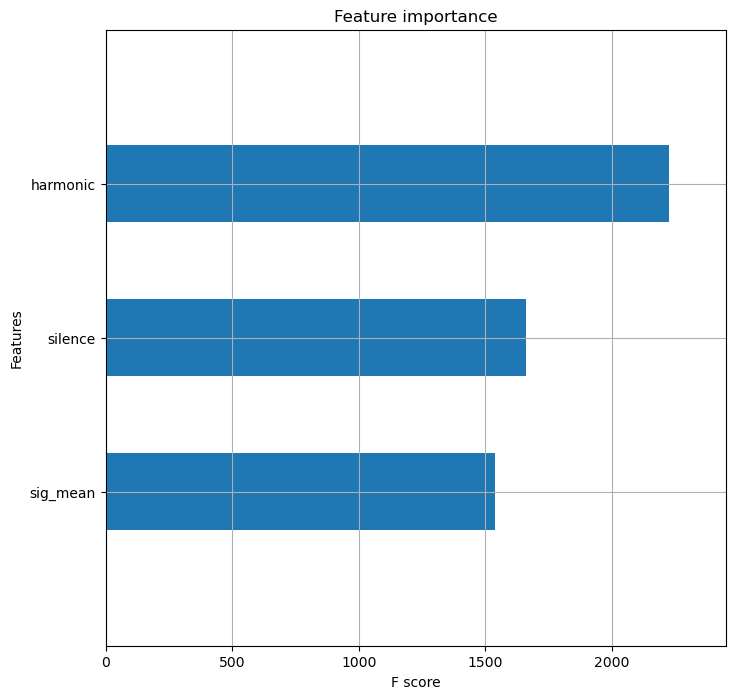

In [15]:
ax = xgb.plot_importance(xgB_classifier, max_num_features=10, height=0.5, show_values=False)
fig = ax.figure
fig.set_size_inches(8, 8)

In [17]:
contribution_scores = xgB_classifier.feature_importances_
contribution_scores

array([0.22483933, 0.        , 0.        , 0.        , 0.36444688,
       0.41071376, 0.        , 0.        ], dtype=float32)

In [18]:
top_n = [3, 5, 6, 7, 8] # number of features
for n in top_n:
    threshold = np.argsort(contribution_scores)[::-1][:n][-1]
    print('Stats for top {} features'.format(n))
    
    # Select features using threshold
    selection = SelectFromModel(xgB_classifier, threshold=contribution_scores[threshold], prefit=True)
    select_x_train = selection.transform(x_train)
    select_x_test = selection.transform(x_test)
    
    # Train
    select_xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.008, objective='multi:softprob', n_estimators=1200, sub_sample = 0.8, num_class = len(emotion_dict), booster='gbtree', n_jobs=4)
    
    # Predict
    pred_probs = select_xgb_classifier.predict_proba(select_x_test)
    
    # Results
    display_result(y_test, pred_probs, cm=False)

Stats for top 3 features


/home/neel/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/neel/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


NotFittedError: need to call fit or load_model beforehand

In [ ]:
# Load predicted probabilities

with open('../preprocessed/rf_classifier.pkl', 'rb') as f:
    rf_pred_probs = pickle.load(f)
    
with open('pred_probas/xgb_classifier.pkl', 'rb') as f:
    xgb_pred_probs = pickle.load(f)
    
with open('pred_probas/svc_classifier_model.pkl', 'rb') as f:
    svc_preds = pickle.load(f)
    
with open('pred_probas/mnb_classifier.pkl', 'rb') as f:
    mnb_pred_probs = pickle.load(f)
    
with open('pred_probas/mlp_classifier.pkl', 'rb') as f:
    mlp_pred_probs = pickle.load(f)
    
with open('pred_probas/lr_classifier.pkl', 'rb') as f:
    lr_pred_probs = pickle.load(f)

with open('pred_probas/lstm_classifier.pkl', 'rb') as f:
    lstm_pred_probs = pickle.load(f)

# Average of the predicted probabilites
ensemble_pred_probs = (xgb_pred_probs +
                       mlp_pred_probs +
                       rf_pred_probs)/3.0
# Show metrics
display_result(y_test, ensemble_pred_probs)